In [94]:
#from google.colab import files
#uploaded = files.upload()

In [1]:
import zipfile
import os

#dataset_path = "/content/Intel Image Classification.zip"
#extract_path = "/content/dataset"

#with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_path)

#print("Dataset extracted successfully!")


In [3]:
# Count classses

dataset_root = r"C:\Users\tim20\Desktop\Study\University\6 semester\DLCV\Project_Hrynchuk\Intel_Image_Classification"

train_dir = os.path.join(dataset_root, "seg_train", "seg_train")
test_dir = os.path.join(dataset_root, "seg_test", "seg_test")
pred_dir = r'C:\Users\tim20\Desktop\Study\University\6 semester\DLCV\Project_Hrynchuk\Intel_Image_Classification\seg_pred\seg_pred'

print("Train Classes:", os.listdir(train_dir))
print("Test Classes:", os.listdir(test_dir))

for folder in os.listdir(train_dir):
    num_images = len(os.listdir(os.path.join(train_dir, folder)))
    print(f"Class '{folder}': {num_images} train images")


Train Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Test Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class 'buildings': 2191 train images
Class 'forest': 2271 train images
Class 'glacier': 2404 train images
Class 'mountain': 2512 train images
Class 'sea': 2274 train images
Class 'street': 2382 train images


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

image_size = (150, 150)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes

print(f"Train split: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Train split: 14034 images
Test set: 3000 images


In [7]:
from PIL import Image
import torchvision.transforms as transforms

class ImageFolderNoClass(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir)
                            if os.path.isfile(os.path.join(root_dir, filename))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

pred_dataset = ImageFolderNoClass(root_dir=pred_dir, transform=transform)
pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)

print(f"Prediction set: {len(pred_dataset)} images")


Prediction set: 7301 images


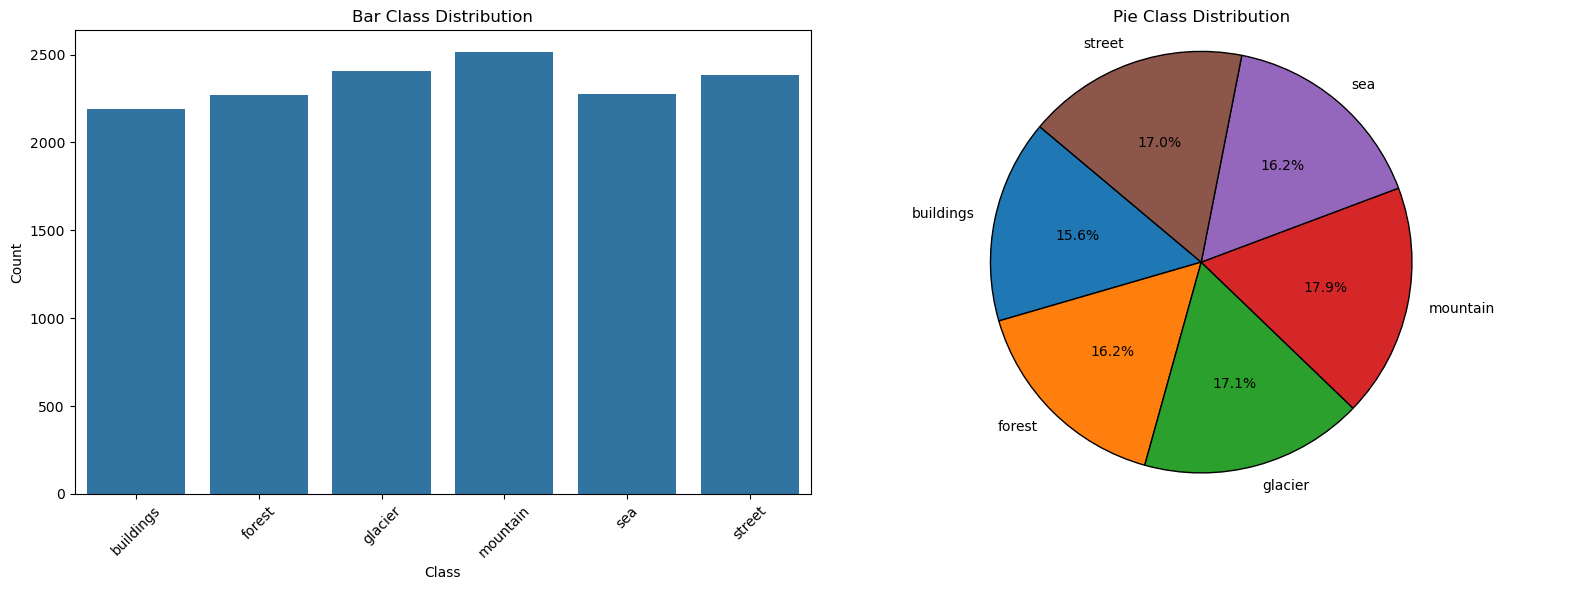

In [9]:
# Chart visualization

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class_counts = Counter([class_names[label] for _, label in train_dataset])
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axs[0])
axs[0].set_title("Bar Class Distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].tick_params(axis='x', rotation=45)

# Pie chart
axs[1].pie(
    list(class_counts.values()),
    labels=list(class_counts.keys()),
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[1].set_title("Pie Class Distribution")
axs[1].axis('equal')

plt.tight_layout()
plt.show()

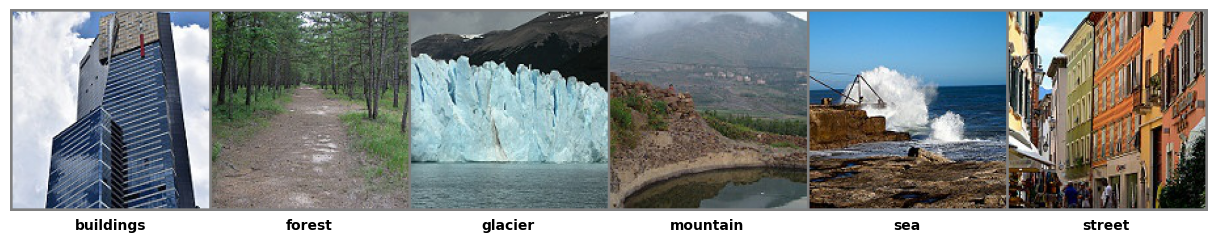

In [11]:
# Visualization

import torchvision
import numpy as np

def imshow_with_labels(images, labels, class_names):
    images = images.cpu()
    images = images / 2 + 0.5
    npimg = images.numpy()

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")

    num_images = len(labels)
    img_width = npimg.shape[2]
    step = img_width // num_images

    for i, label in enumerate(labels):
        class_name = class_names[label]
        x_pos = step * i + step // 2
        ax.text(x_pos, npimg.shape[1] + 5, class_name, ha='center', va='top',
                fontsize=10, color='black', fontweight="bold")

    plt.tight_layout(pad=0.1)
    plt.show()

def get_one_image_per_class(loader, num_classes):
    class_seen = [False] * num_classes
    images_per_class = [None] * num_classes
    labels_per_class = [None] * num_classes

    for images, labels in loader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if not class_seen[lbl]:
                class_seen[lbl] = True
                images_per_class[lbl] = img
                labels_per_class[lbl] = lbl
            if all(class_seen):
                return torch.stack(images_per_class), torch.tensor(labels_per_class)
    raise RuntimeError("Not enough classes found in the data.")

images, labels = get_one_image_per_class(test_loader, num_classes=6)
imshow_with_labels(torchvision.utils.make_grid(images, padding=2), labels, test_loader.dataset.classes)

**Висновок:**

Запропонований датасет збалансований і організований, всі класи мають схожу кількість зображень, вибірка поділяється 1 до 5, як тестові до навчальний данних, що є хорошим співвідношенням.

Також я реалізував попередню обробку зображень, включаючи перетворення до тензорів, нормалізацію, а також аугментацію для підвищення загальної якості навчання. Крім того, розділив навчальну вибірку на навчальну та валідаційну підмножини у співвідношенні 80:20, що дозволяє більш точно оцінювати продуктивність моделі під час тренування.


In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
# GPU

#print(torch.cuda.get_device_properties())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN(num_classes=len(class_names)).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

num_epochs = 30

train_losses, train_accs, train_recs, train_precs, train_f1s = [], [], [], [], []
test_losses, test_accs, test_recs, test_precs, test_f1s = [], [], [], [], []

print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Acc':>6} | {'Rec':>6} | {'Prec':>6} | {'F1':>6} || "
          f"{'Val Loss':>9} | {'Val Acc':>7} | {'Val Rec':>7} | {'Val Prec':>9} | {'Val F1':>8}")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_accs.append(train_acc)
    train_recs.append(train_rec)
    train_precs.append(train_prec)
    train_f1s.append(train_f1)

    # ----- Validation -----
    model.eval()
    total_test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    epoch_test_loss = total_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_rec = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
    
    test_accs.append(test_acc)
    test_recs.append(test_rec)
    test_precs.append(test_prec)
    test_f1s.append(test_f1)

    print(f"{epoch+1:5d} | {epoch_train_loss:10.4f} | {train_acc:6.4f} | {train_rec:6.4f} | {train_prec:6.4f} | {train_f1:6.4f} || "
      f"{epoch_test_loss:9.4f} | {test_acc:7.4f} | {test_rec:7.4f} | {test_prec:9.4f} | {test_f1:8.4f}")

Epoch | Train Loss |    Acc |    Rec |   Prec |     F1 ||  Val Loss | Val Acc | Val Rec |  Val Prec |   Val F1
    1 |     0.9933 | 0.6107 | 0.6107 | 0.6057 | 0.6064 ||    0.7505 |  0.7293 |  0.7293 |    0.7390 |   0.7287
    2 |     0.6796 | 0.7490 | 0.7490 | 0.7488 | 0.7489 ||    0.5417 |  0.8067 |  0.8067 |    0.8141 |   0.8061
    3 |     0.5451 | 0.8054 | 0.8054 | 0.8052 | 0.8053 ||    0.5003 |  0.8257 |  0.8257 |    0.8286 |   0.8253
    4 |     0.4793 | 0.8294 | 0.8294 | 0.8294 | 0.8293 ||    0.4784 |  0.8393 |  0.8393 |    0.8439 |   0.8402
    5 |     0.4189 | 0.8499 | 0.8499 | 0.8499 | 0.8499 ||    0.5034 |  0.8263 |  0.8263 |    0.8346 |   0.8276
    6 |     0.3904 | 0.8610 | 0.8610 | 0.8608 | 0.8609 ||    0.4557 |  0.8490 |  0.8490 |    0.8526 |   0.8495
    7 |     0.3495 | 0.8743 | 0.8743 | 0.8743 | 0.8743 ||    0.4706 |  0.8460 |  0.8460 |    0.8483 |   0.8459
    8 |     0.3020 | 0.8938 | 0.8938 | 0.8938 | 0.8937 ||    0.4853 |  0.8483 |  0.8483 |    0.8513 |   0.8489
 

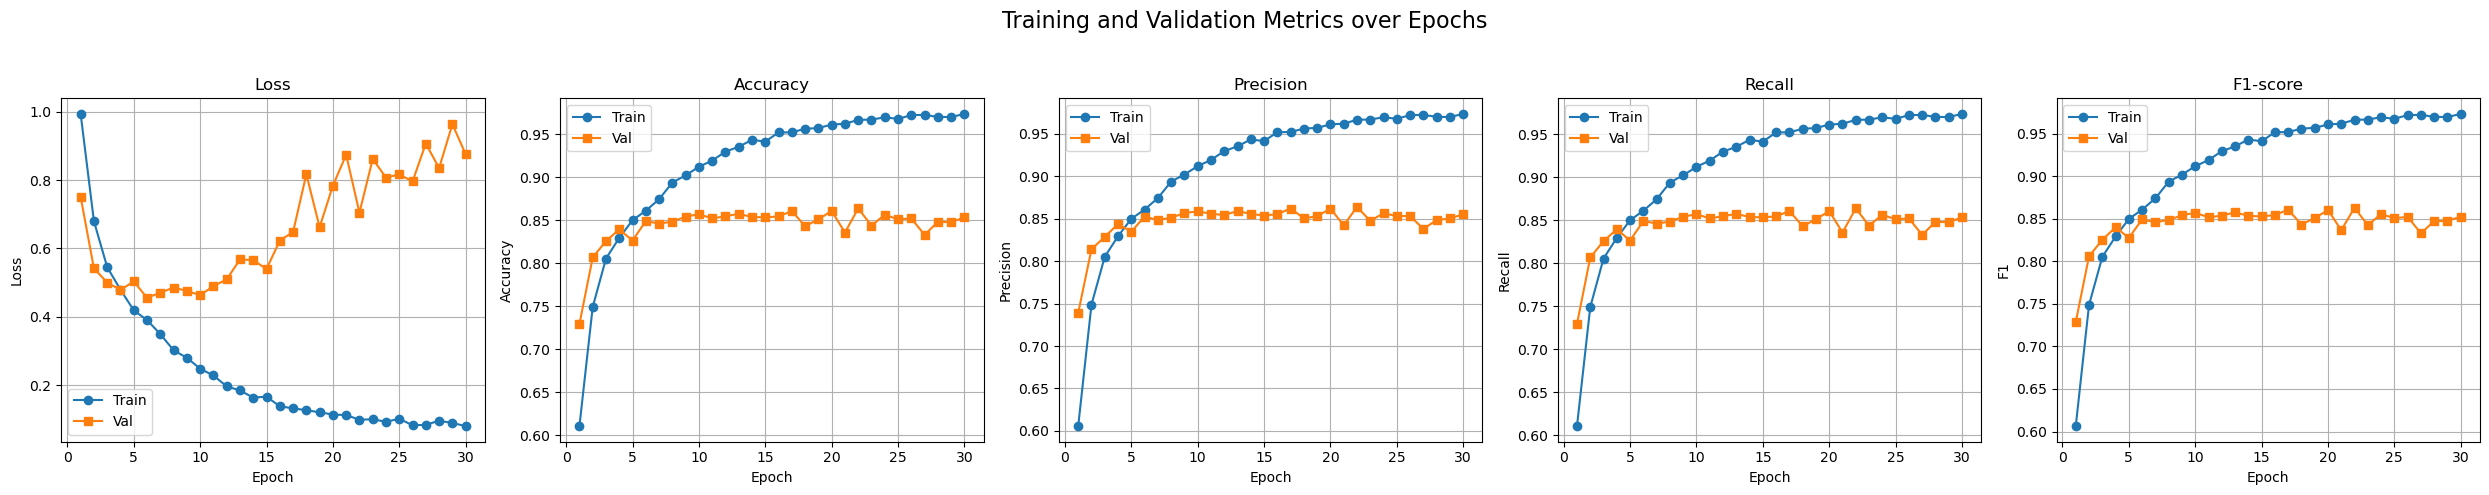

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
fig.suptitle("Training and Validation Metrics over Epochs", fontsize=16)

# Loss
axs[0].plot(epochs, train_losses, label='Train', marker='o')
axs[0].plot(epochs, test_losses, label='Val', marker='s')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(epochs, train_accs, label='Train', marker='o')
axs[1].plot(epochs, test_accs, label='Val', marker='s')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

# Precision
axs[2].plot(epochs, train_precs, label='Train', marker='o')
axs[2].plot(epochs, test_precs, label='Val', marker='s')
axs[2].set_title("Precision")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Precision")
axs[2].legend()
axs[2].grid(True)

# Recall
axs[3].plot(epochs, train_recs, label='Train', marker='o')
axs[3].plot(epochs, test_recs, label='Val', marker='s')
axs[3].set_title("Recall")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Recall")
axs[3].legend()
axs[3].grid(True)

# F1
axs[4].plot(epochs, train_f1s, label='Train', marker='o')
axs[4].plot(epochs, test_f1s, label='Val', marker='s')
axs[4].set_title("F1-score")
axs[4].set_xlabel("Epoch")
axs[4].set_ylabel("F1")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



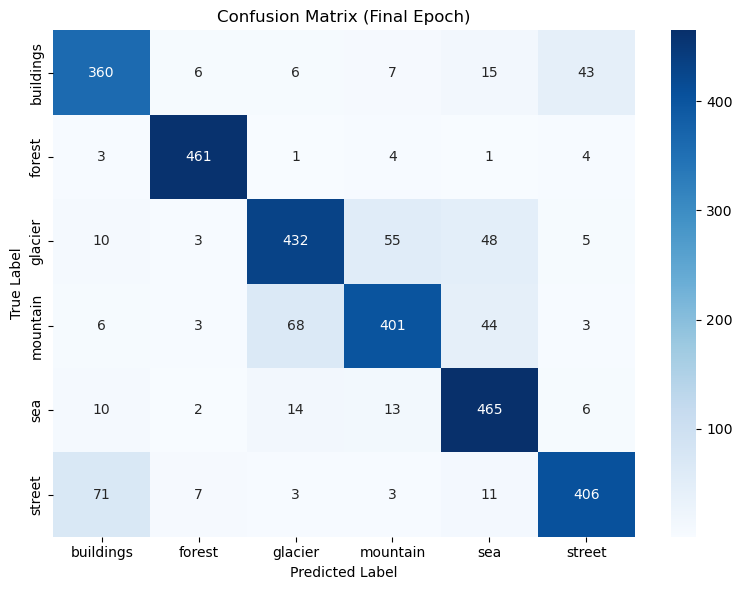

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set model to eval mode
model.eval()

# Collect predictions on test set
all_preds, all_targets = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(class_names))))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Final Epoch)")
plt.tight_layout()
plt.show()
